###利用bike-sharing数据集构建回归模型

首先加载和查看数据集

In [155]:
for line in open('data/Readme.txt').readlines():
    print line.strip()
rawdata = sc.textFile('data/hour.csv')
data = rawdata.map(lambda x:x.split(','))
for i in data.take(5):
    print i

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual us

可以看到第一行为标签，第一列instance为序号可以删除，第二列dteday为日期，信息已包含在之后的yr，mnth等变量中，可以删除。此次预测只预测总数量，因此去除casual和registered。剩下的变量分别为：季节，年，月，小时，节假日，星期几，工作日，天气，温度，体感温度，湿度，风速。其中后四个变量已标准化。

In [156]:
data = data.filter(lambda x: x[0] != 'instant')
data.cache()
print data.count()

17379


我打算用线性回归和决策树两种方法来尝试拟合数据集，在线性回归中，对类型变量进行二元编码。（决策树中不需要）建立辅助函数并转换数据。

In [157]:
def binary_encode(rdd, i):
    return (rdd.
           map(lambda x :x[i])
           .distinct()
           .zipWithIndex()
           .collectAsMap())
#对第2-9列应用该函数得到转换的字典
mappings = [binary_encode(data,i) for i in range(2,10)]
print mappings
#将第2-9列转换为二元编码
from pyspark.mllib.regression import LabeledPoint
import numpy as np
def extract_feature(line):
    lst = []
    for ind in range(2,10):
        dic = mappings[ind-2]
        for i,j in dic.iteritems():
            if line[ind] == i:
                lst.append(1.0)
            else:
                lst.append(0)
    for ind in range(10,14):
        lst.append(line[ind])
    return np.array(map(float,lst))
def extract_label(line):
    return float(line[-1])

binarydata = data.map(lambda x : LabeledPoint(extract_label(x), extract_feature(x)))
print binarydata.first()
print 'Raw data: '+ str(data.first()[2:])
print 'Raw Label: ' + str(data.first()[-1])
print 'Binary data: ' + str(binarydata.first().features)
print 'Binary label: '+ str(binarydata.first().label)
print 'Features number: ' + str(len(binarydata.first().features))

[{u'1': 0, u'3': 1, u'2': 2, u'4': 3}, {u'1': 0, u'0': 1}, {u'11': 0, u'10': 1, u'12': 2, u'1': 3, u'3': 4, u'2': 5, u'5': 6, u'4': 7, u'7': 8, u'6': 9, u'9': 10, u'8': 11}, {u'20': 0, u'21': 1, u'22': 2, u'23': 3, u'1': 4, u'0': 5, u'3': 6, u'2': 7, u'5': 8, u'4': 9, u'7': 10, u'6': 11, u'9': 12, u'8': 13, u'11': 14, u'10': 15, u'13': 16, u'12': 17, u'15': 18, u'14': 19, u'17': 20, u'16': 21, u'19': 22, u'18': 23}, {u'1': 0, u'0': 1}, {u'1': 0, u'0': 1, u'3': 2, u'2': 3, u'5': 4, u'4': 5, u'6': 6}, {u'1': 0, u'0': 1}, {u'1': 0, u'3': 1, u'2': 2, u'4': 3}]
(16.0,[1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0])
Raw data: [u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
Raw Label: 16
Binary data: [1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1

决策树中可以直接使用原始数据，因此只需要将u'1'格式转换为float，再用numpy封装一下

In [158]:
def extract_float(line):
    return np.array(line[2:14])
treedata = data.map(lambda x: LabeledPoint(extract_label(x), extract_float(x)))
print 'Raw data: '+ str(data.first()[2:])
print 'Raw Label: ' + str(data.first()[-1])
print 'Desicion tree data: ' + str(treedata.first().features)
print 'Desicion tree Label: ' + str(treedata.first().label)

Raw data: [u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
Raw Label: 16
Desicion tree data: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Desicion tree Label: 16.0


训练线性回归模型和决策树模型

In [159]:
from pyspark.mllib.regression import LinearRegressionWithSGD

linear_model = LinearRegressionWithSGD.train(binarydata, iterations = 10, step = 0.1, intercept = False)
linear_pred_act = binarydata.map(lambda x: (linear_model.predict(x.features),x.label))
print 'linear predictions vs actual:'
print linear_pred_act.take(5)

linear predictions vs actual:
[(135.94648455498353, 16.0), (134.38058174607252, 40.0), (134.18407938613737, 32.0), (133.88699144084512, 13.0), (133.77899037657545, 1.0)]


In [160]:
from pyspark.mllib.tree import DecisionTree
tree_model = DecisionTree.trainRegressor(treedata,{})
preds = tree_model.predict(treedata.map(lambda x:x.features))
actual = treedata.map(lambda x: x.label)
tree_pred_act = preds.zip(actual)
print tree_pred_act.take(5)
print tree_model.depth()
print tree_model.numNodes()

[(54.913223140495866, 16.0), (54.913223140495866, 40.0), (53.171052631578945, 32.0), (14.284023668639053, 13.0), (14.284023668639053, 1.0)]
5
63


评估模型的性能，采用均方误差，平均绝对误差，均方根对数误差

In [161]:
def squared_error(i,j):
    return (i-j)**2
def abs_error(i,j):
    return np.abs(i-j)
def square_log_error(i,j):
    return(np.log(i+1) - np.log(j+1))**2

In [162]:
mse = linear_pred_act.map(lambda (i,j): squared_error(i,j)).mean()
mae = linear_pred_act.map(lambda (i,j): abs_error(i,j)).mean()
rmsle = np.sqrt(linear_pred_act.map(lambda (i,j): square_log_error(i,j)).mean())
print 'mean squared error: '+ str(mse)
print 'mean absolute error: ' + str(mae)
print 'rot mean squred log error: ' + str(rmsle)

mean squared error: 29897.3402015
mean absolute error: 130.532559912
rot mean squred log error: 1.48038670632


In [163]:
tree_mse = tree_pred_act.map(lambda (i,j): squared_error(i,j)).mean()
tree_mae = tree_pred_act.map(lambda (i,j): abs_error(i,j)).mean()
tree_rmsle = np.sqrt(tree_pred_act.map(lambda (i,j): square_log_error(i,j)).mean())
print 'desicion tree mean squared error: '+ str(tree_mse)
print 'desicion tree mean absolute error: ' + str(tree_mae)
print 'desicion tree rot mean squred log error: ' + str(tree_rmsle)

desicion tree mean squared error: 11611.4859995
desicion tree mean absolute error: 71.1501878649
desicion tree rot mean squred log error: 0.625115258696


(array([  7.96372860e-03,   3.40527809e-03,   2.69781034e-03,
          2.37473340e-03,   2.27568792e-03,   2.24503098e-03,
          2.12240324e-03,   2.09410453e-03,   1.80875921e-03,
          1.71207195e-03,   1.37720388e-03,   1.37248743e-03,
          1.23099388e-03,   9.64514361e-04,   8.53677747e-04,
          8.65468877e-04,   6.83885488e-04,   5.94272907e-04,
          5.70690649e-04,   4.78719842e-04,   5.02302100e-04,
          3.72599680e-04,   3.49017422e-04,   3.39584518e-04,
          2.52330163e-04,   2.26389679e-04,   2.02807421e-04,
          1.88658066e-04,   1.50926453e-04,   1.29702420e-04,
          9.90454845e-05,   6.36720972e-05,   8.72543554e-05,
          1.01403710e-04,   8.25379038e-05,   5.65974197e-05,
          4.71645164e-05,   1.17911291e-05,   9.43290329e-06,
          1.88658066e-05]),
 array([   1. ,   25.4,   49.8,   74.2,   98.6,  123. ,  147.4,  171.8,
         196.2,  220.6,  245. ,  269.4,  293.8,  318.2,  342.6,  367. ,
         391.4,  415.8

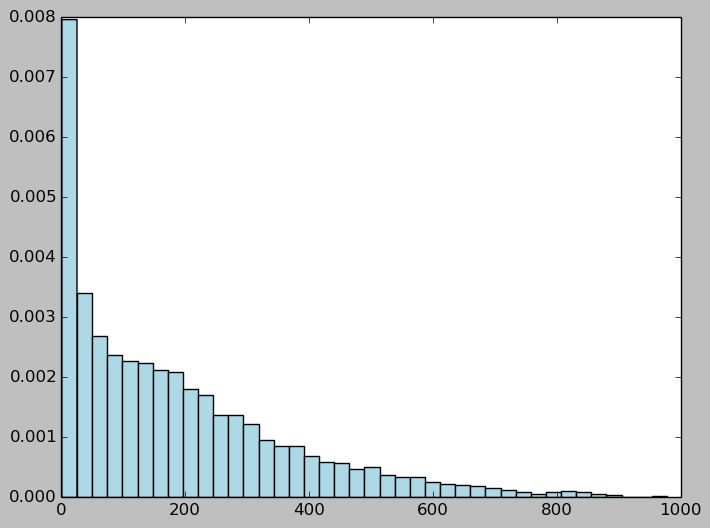

In [164]:
import matplotlib.pyplot as plt
targets = data.map(lambda x:float(x[-1])).collect()
plt.hist(targets,bins = 40,normed = True,color = 'lightblue')

尝试取对数和平方根

(array([ 0.05282272,  0.        ,  0.        ,  0.        ,  0.06953877,
         0.        ,  0.0748879 ,  0.        ,  0.07722815,  0.08692346,
         0.07889975,  0.06619556,  0.10363951,  0.10096494,  0.07856543,
         0.0621837 ,  0.0956158 ,  0.10497679,  0.1066484 ,  0.1210242 ,
         0.12871358,  0.12135852,  0.13172247,  0.15245037,  0.16649185,
         0.19190025,  0.23235309,  0.26545087,  0.30122321,  0.3376642 ,
         0.38012297,  0.39516741,  0.36842173,  0.3423447 ,  0.30824395,
         0.24472297,  0.20661037,  0.14275506,  0.07689383,  0.03543803]),
 array([ 0.        ,  0.17211217,  0.34422433,  0.5163365 ,  0.68844867,
         0.86056083,  1.032673  ,  1.20478516,  1.37689733,  1.5490095 ,
         1.72112166,  1.89323383,  2.065346  ,  2.23745816,  2.40957033,
         2.58168249,  2.75379466,  2.92590683,  3.09801899,  3.27013116,
         3.44224333,  3.61435549,  3.78646766,  3.95857982,  4.13069199,
         4.30280416,  4.47491632,  4.64702849,  4

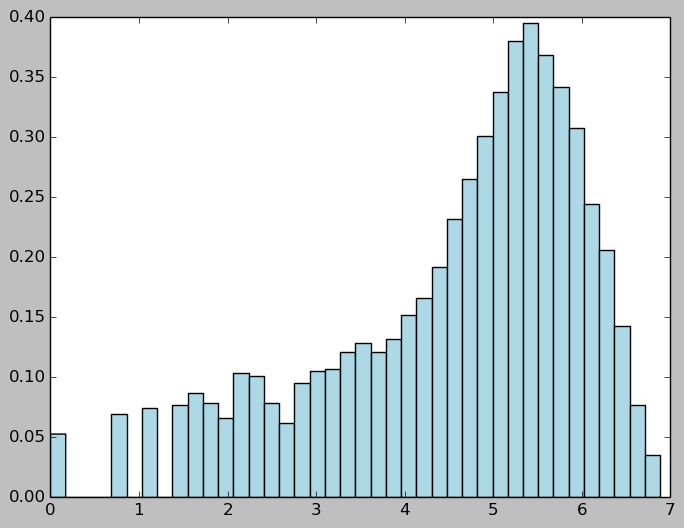

In [165]:
plt.hist(np.log(targets),bins = 40,normed = True,color = 'lightblue')

(array([ 0.04488088,  0.05530237,  0.05043394,  0.05119463,  0.0376543 ,
         0.04609799,  0.04297915,  0.03818678,  0.03887141,  0.04510909,
         0.04001245,  0.04746724,  0.04982538,  0.05073822,  0.05203139,
         0.05385706,  0.05781266,  0.0512707 ,  0.05553058,  0.04564157,
         0.04609799,  0.04214239,  0.03818678,  0.03149269,  0.03217731,
         0.02852598,  0.0222883 ,  0.02198402,  0.02122333,  0.01589848,
         0.01597455,  0.01080184,  0.00988901,  0.00882404,  0.00585734,
         0.00425988,  0.00547699,  0.00342312,  0.00167352,  0.00091283]),
 array([  1.        ,   1.75642498,   2.51284996,   3.26927494,
          4.02569992,   4.7821249 ,   5.53854988,   6.29497486,
          7.05139984,   7.80782482,   8.5642498 ,   9.32067478,
         10.07709976,  10.83352475,  11.58994973,  12.34637471,
         13.10279969,  13.85922467,  14.61564965,  15.37207463,
         16.12849961,  16.88492459,  17.64134957,  18.39777455,
         19.15419953,  19.9106

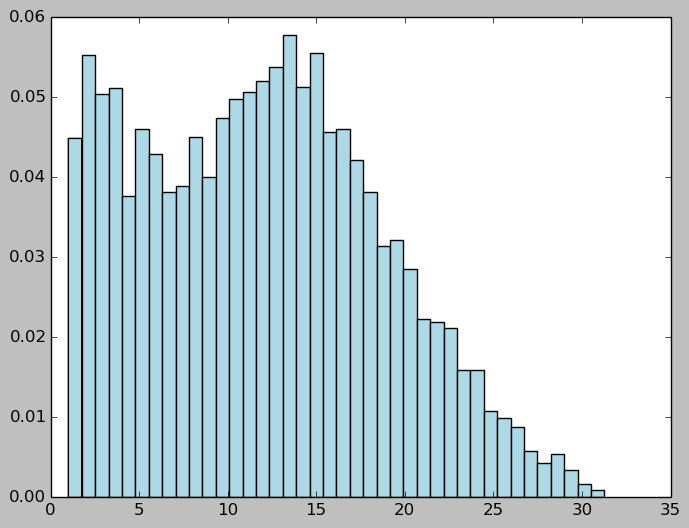

In [166]:
plt.hist(np.sqrt(targets),bins = 40,normed = True,color = 'lightblue')

接下来尝试用对数拟合模型

In [167]:
binarydata_log = binarydata.map(lambda x: LabeledPoint(np.log(x.label), x.features))
linear_model_log = LinearRegressionWithSGD.train(binarydata_log, iterations = 10, step = 0.1, intercept = False)
linear_pred_act_log = binarydata_log.map(lambda x: (np.exp(linear_model_log.predict(x.features)),np.exp(x.label)))
print 'linear predictions vs actual:'
print linear_pred_act_log.take(5)
mse = linear_pred_act_log.map(lambda (i,j): squared_error(i,j)).mean()
mae = linear_pred_act_log.map(lambda (i,j): abs_error(i,j)).mean()
rmsle = np.sqrt(linear_pred_act_log.map(lambda (i,j): square_log_error(i,j)).mean())
print 'mean squared error: '+ str(mse)
print 'mean absolute error: ' + str(mae)
print 'rot mean squred log error: ' + str(rmsle)

linear predictions vs actual:
[(40.91617570453451, 15.999999999999998), (39.374013505300653, 40.0), (38.932873447929204, 32.0), (38.068727061376421, 13.0), (37.834766952897375, 1.0)]
mean squared error: 47024.5721598
mean absolute error: 149.288618818
rot mean squred log error: 1.45256325985


In [168]:
treedata_log = treedata.map(lambda x:LabeledPoint(np.log(x.label), x.features))
tree_model_log = DecisionTree.trainRegressor(treedata_log,{})
preds_log = tree_model_log.predict(treedata_log.map(lambda x:x.features)).map(lambda x: np.exp(x))
actual_log = treedata_log.map(lambda x: x.label).map(lambda x: np.exp(x))
tree_pred_act_log = preds_log.zip(actual_log)

tree_mse_log = tree_pred_act_log.map(lambda (i,j): squared_error(i,j)).mean()
tree_mae_log = tree_pred_act_log.map(lambda (i,j): abs_error(i,j)).mean()
tree_rmsle_log = np.sqrt(tree_pred_act_log.map(lambda (i,j): square_log_error(i,j)).mean())
print 'desicion tree mean squared error: '+ str(tree_mse_log)
print 'desicion tree mean absolute error: ' + str(tree_mae_log)
print 'desicion tree rot mean squred log error: ' + str(tree_rmsle_log)

desicion tree mean squared error: 14781.5759883
desicion tree mean absolute error: 76.4131099112
desicion tree rot mean squred log error: 0.640599610072


可以看到取对数对模型效果影响不大

创建训练集和测试集,测试不同参数对模型性能的影响

In [169]:
data_with_index = binarydata.zipWithIndex().map(lambda (i,j): (j,i))
test = data_with_index.sample(False,0.2,42)
train = data_with_index.subtractByKey(test)
train_data = train.map(lambda (i,j):j)
test_data = test.map(lambda (i,j):j)
train_size = train_data.count()
test_size = test_data.count()
print "Training data size: %d" % train_size
print "Test data size: %d" % test_size

Training data size: 13843
Test data size: 3536


In [170]:
tree_data_with_index = treedata.zipWithIndex().map(lambda (i,j): (j,i))
tree_test = tree_data_with_index.sample(False,0.2,42)
tree_train = tree_data_with_index.subtractByKey(tree_test)
tree_train_data = train.map(lambda (i,j):j)
tree_test_data = test.map(lambda (i,j):j)

In [171]:
def evaluate(train,test,iterations ,step,regParam,regType,intercept):
    model = LinearRegressionWithSGD.train(train,iterations,step,regParam = regParam,regType = regType, intercept = intercept)
    tp = test.map(lambda x:(x.label,model.predict(x.features)))
    rmsle = np.sqrt(tp.map(lambda(i,j): square_log_error(i,j)).mean())
    return rmsle

[1, 5, 10, 20, 50, 100, 200, 500, 1000]
[2.8032563666537595, 1.9645810957004637, 1.7086221968290249, 1.5255705039801279, 1.3966970293255028, 1.3733178276026903, 1.3921362057047302, 1.440916089834078, 1.4702238639466663]


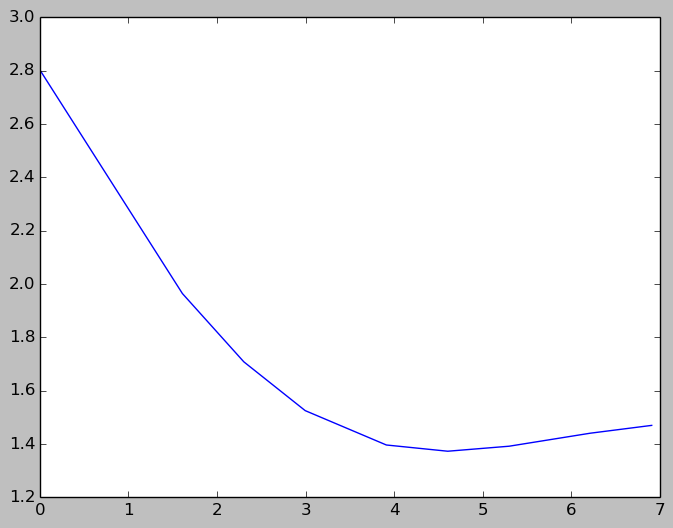

In [172]:
params = [1,5,10,20,50,100,200,500,1000]
metrics = [evaluate(train_data,test_data,param,0.01,0.0,'l2',False) for param in params]
print params
print metrics
plt.plot(np.log(params),metrics)

[0.01, 0.025, 0.05, 0.1, 1]
[1.7086221968290249, 1.3961771685298445, 1.392659943805455, 1.4697573635648185, nan]


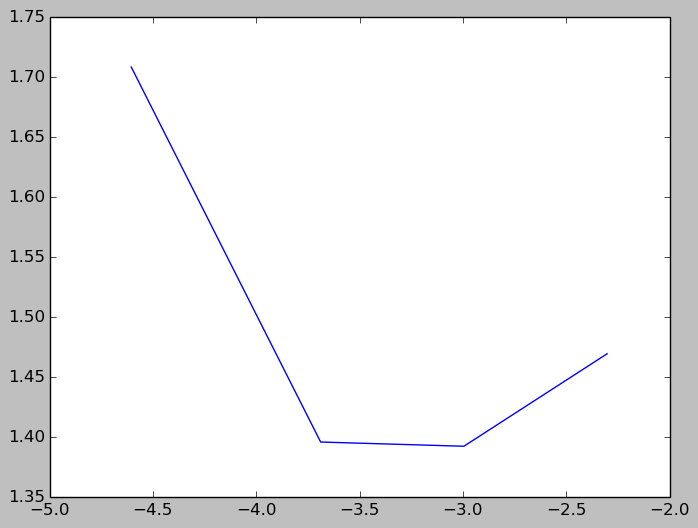

In [173]:
params = [0.01,0.025,0.05,0.1,1]
metrics = [evaluate(train_data,test_data,10,param,0.0,'l2',False) for param in params]
print params
print metrics
plt.plot(np.log(params),metrics)

[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.4697573635648185, 1.469113028540231, 1.4634188057285833, 1.4165237605797092, 1.376225790336346, 1.4904349424828804, 1.7653588820071182]


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


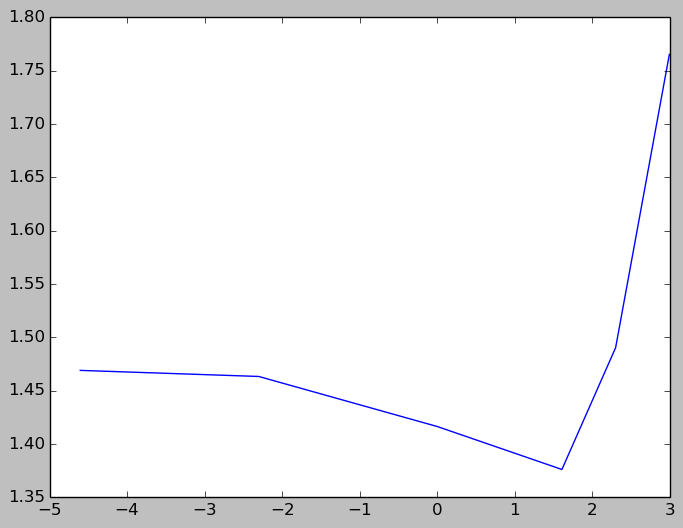

In [174]:
params = [0.0,0.01,0.1,1.0,5.0,10.0,20.0]
metrics = [evaluate(train_data,test_data,10,0.1,param,'l2',False) for param in params]
print params
print metrics
plt.plot(np.log(params),metrics)

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.4697573635648185, 1.4697190854099258, 1.4693749895529875, 1.466217949786879, 1.4386546455290785, 1.6683522645623436, 4.7975574647546564]


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


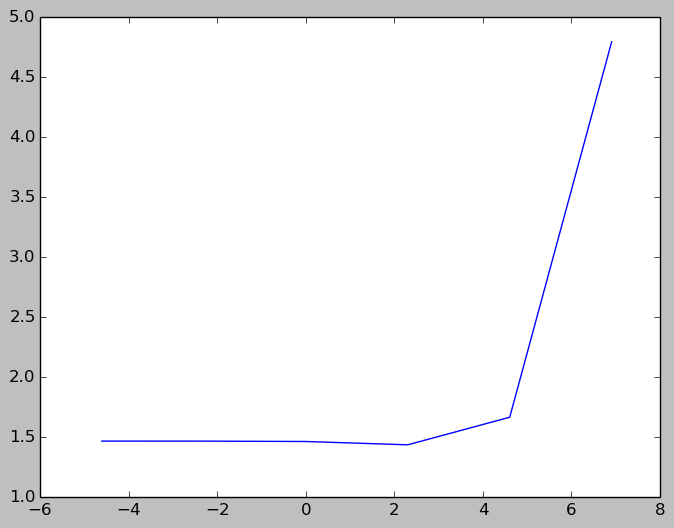

In [175]:
params = [0.0,0.01,0.1,1.0,10.0,100.0,1000.0]
metrics = [evaluate(train_data,test_data,10,0.1,param,'l1',False) for param in params]
print params
print metrics
plt.plot(np.log(params),metrics)

[False, True]
[1.466217949786879, 1.4931703614325664]


<Container object of 2 artists>

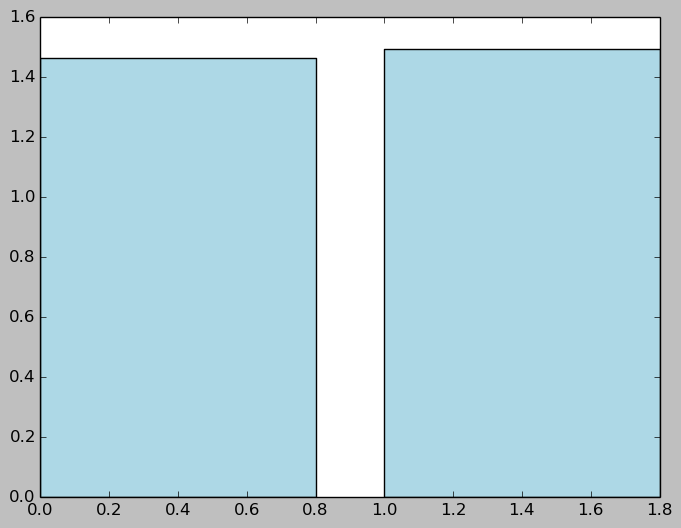

In [176]:
params = [False,True]
metrics = [evaluate(train_data,test_data,10,0.1,1.0,'l1',param) for param in params]
print params
print metrics
plt.bar(params,metrics,color = 'lightblue')

可以发现线性回归模型的rmsle一直比较大，因此尝试优化决策树的参数

In [177]:
def tree_evaluate(train,test,maxDepth,maxBins):
    model = DecisionTree.trainRegressor(train,{},impurity = 'variance', maxDepth = maxDepth, maxBins = maxBins)
    preds = model.predict(test.map(lambda x:x.features))
    actual = test.map(lambda x:x.label)
    tp = actual.zip(preds)
    rmsle = np.sqrt(tp.map(lambda (i,j): square_log_error(i,j)).mean())
    return rmsle

[1, 2, 3, 4, 5, 10, 20]
[1.4769680346251848, 1.4463996287263496, 1.4052970275150503, 1.3706730389096726, 1.3133800087056628, 1.06096810331115, 0.59356773203374946]


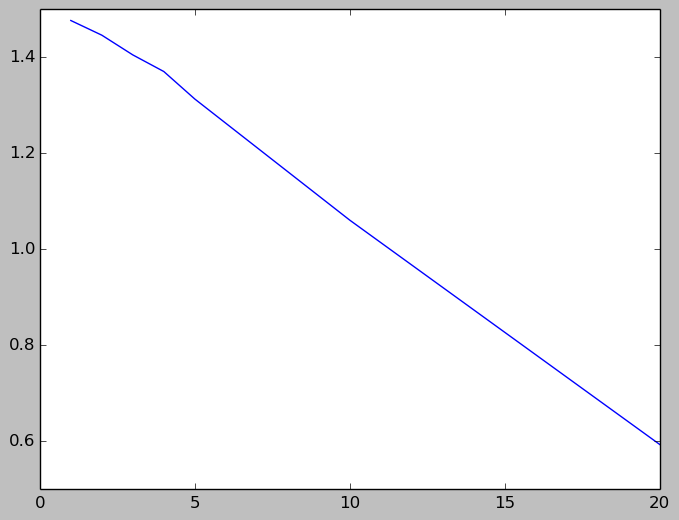

In [178]:
params = [1,2,3,4,5,10,20]
metrics = [tree_evaluate(tree_train_data,tree_test_data,param,32) for param in params]
print params
print metrics
plt.plot(params,metrics)

[2, 4, 8, 16, 32, 64, 100]
[0.54228074209636057, 0.5392012822568224, 0.58411806921283194, 0.59365764578073632, 0.59716251683048815, 0.62105899611168236, 0.6278350415424504]


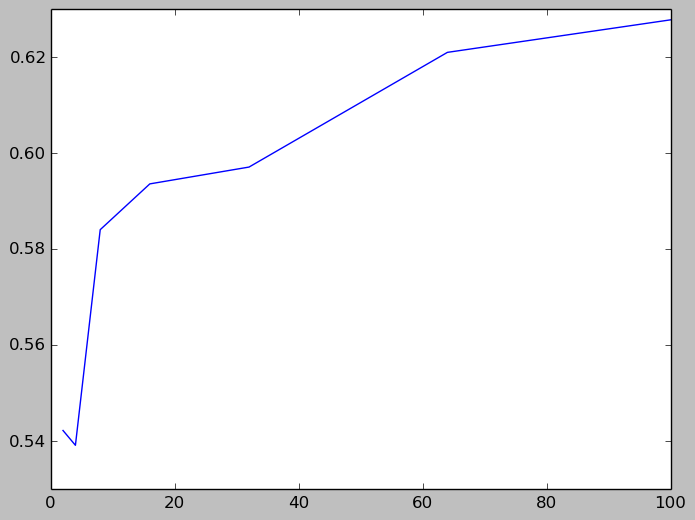

In [179]:
params = [2,4,8,16,32,64,100]
metrics = [tree_evaluate(tree_train_data,tree_test_data,20,param) for param in params]
print params
print metrics
plt.plot(params,metrics)

得到的最小的RMSLE 0.539